In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 
import json

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def loadSigmaFiles(fpath):
    limits = {}
    sigmas = {}
    for f in glob.glob(fpath):
        fname = f.split("/")[-1]        
        ct = fname.split("_")[4].replace("pl","")
        mass = float(fname.split("_")[3].replace("mHNL","").replace("p","."))
        xsec = f_xsec(mass)(float(ct))
        channel = "ele" if "ele" in fname.split("_")[2] else "muon"
        region = fname.split("_")[-1].split(".")[0]  # CSC or DT
        signalName = "_".join(fname.split("_")[1:5])
        cutstring = fname.split("_")[5:8]
        sizeCut = float(cutstring[0].replace("s",""))
        lepCut = float(cutstring[1].replace("lep",""))   
        try:
            metCut = float(cutstring[2].replace("met",""))   
        except ValueError:
            metCut = np.round(np.pi,2)           

        sigma = loadLimits(f)        
        sigmas[(sizeCut,lepCut,metCut)] = sigma
            
    return sigmas

def loadLimitFiles(fpath):
    limits = {}
    limits_up = {}    
    limits_down = {}        
    bkg_yields = {}
    sig_yields = {}    
    for f in glob.glob(fpath):
        #cutname = "s%s_lep%s_met%s"%(int(cut[0]),np.round(cut[1],2),str(cut[2]))
        #fpathDT = baseDir + "higgsCombine_HNL_electronType_mHNL4p0_pl1000_%s_DT.AsymptoticLimits.mH120.root"%(cutname)
        fname = f.split("/")[-1]        
        ct = fname.split("_")[4].replace("pl","")
        mass = float(fname.split("_")[3].replace("mHNL","").replace("p","."))
        xsec = f_xsec(mass)(float(ct))
        channel = "ele" if "ele" in fname.split("_")[2] else "muon"
        region = fname.split("_")[-1].split(".")[0]  # CSC or DT
        signalName = "_".join(fname.split("_")[1:5])
        cutstring = fname.split("_")[5:8]
        sizeCut = float(cutstring[0].replace("s",""))
        lepCut = float(cutstring[1].replace("lep",""))   
        try:
            metCut = float(cutstring[2].replace("met",""))   
        except ValueError:
            metCut = np.round(np.pi,2)           

        limit = loadLimits(f)     
        if "Significance" in fname:
            limits[(sizeCut,lepCut,metCut)] = limit # load significance
        elif len(limit) !=6 and "AsymptoticLimits" in f:
            print("Problem loading limit for ",fname)
        else:
            limits[(sizeCut,lepCut,metCut)] = xsec*limit[2] ##load expected limits 
            limits_up[(sizeCut,lepCut,metCut)] = xsec*limit[3]              
            limits_down[(sizeCut,lepCut,metCut)] = xsec*limit[1]                          

        fyields = "/".join(f.split("/")[:-1])+"/yields_{}_{}_{}.json".format(channel,region,"_".join(cutstring))
        with open(fyields,"r") as f:
            yields_all = json.load(f)
        bkg_yields[(sizeCut,lepCut,metCut)] = yields_all['bkg'][region]
        sig_yields[(sizeCut,lepCut,metCut)] = yields_all[signalName][region]   
        
            
    return limits,bkg_yields,sig_yields,limits_up,limits_down

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True, legend=True):

    # expected CLs
    if legend:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$")
    else:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label='_nolegend_')        
    

    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")

    
    return ax

## return the xsec function for mass=X
from HNLprocessor.util import f_xsec
## return the V^2 function for ctau
from HNLprocessor.util import f_v2


## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
#         rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
        if f=="linear":
            rbfi = interp1d(x, y,fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            

        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs



In [54]:
ele_DT.values()

dict_values([0.20629499999999695, 0.20983437499999688, 0.21741874999999677, 0.24168874999999643, 0.29528499999999563, 0.3943874999999942])

In [55]:
ele_DTdown.values()

dict_values([0.13608620361327925, 0.1364871175765971, 0.13976824855804237, 0.15414591022491228, 0.18325548583984103, 0.2407150268554652])

In [53]:
ele_DTup.values()

dict_values([0.32717319854735843, 0.338641325340266, 0.3560812216186471, 0.3996833540344179, 0.5000862398147509, 0.6867879315948384])

In [46]:
ele_DT,ele_DT_bkg_yields,ele_DT_sig_yields,ele_DTup,ele_DTdown = loadLimitFiles(fpath_eleDT)

In [81]:
baseDir = "../limit/combine/HNL_datacards/scan_v4/"
fpath_eleDT = baseDir + "higgsCombine_HNL_electronType_mHNL4p0_pl1000_*_DT.AsymptoticLimits.mH120.root"
fpath_muDT  = baseDir + "higgsCombine_HNL_muonType_mHNL4p0_pl1000_*_DT.AsymptoticLimits.mH120.root"

fpath_eleCSC = baseDir + "higgsCombine_HNL_electronType_mHNL4p0_pl1000_*_CSC.AsymptoticLimits.mH120.root"
fpath_muCSC  = baseDir + "higgsCombine_HNL_muonType_mHNL4p0_pl1000_*_CSC.AsymptoticLimits.mH120.root"

ele_DT,ele_DT_bkg_yields,ele_DT_sig_yields,ele_DTup,ele_DTdown = loadLimitFiles(fpath_eleDT)
mu_DT ,mu_DT_bkg_yields ,mu_DT_sig_yields,mu_DTup,mu_DTdown = loadLimitFiles(fpath_muDT)

mu_CSC ,mu_CSC_bkg_yields ,mu_CSC_sig_yields,mu_CSCup,mu_CSCdown = loadLimitFiles(fpath_muCSC)
ele_CSC,ele_CSC_bkg_yields,ele_CSC_sig_yields,ele_CSCup,ele_CSCdown = loadLimitFiles(fpath_eleCSC)


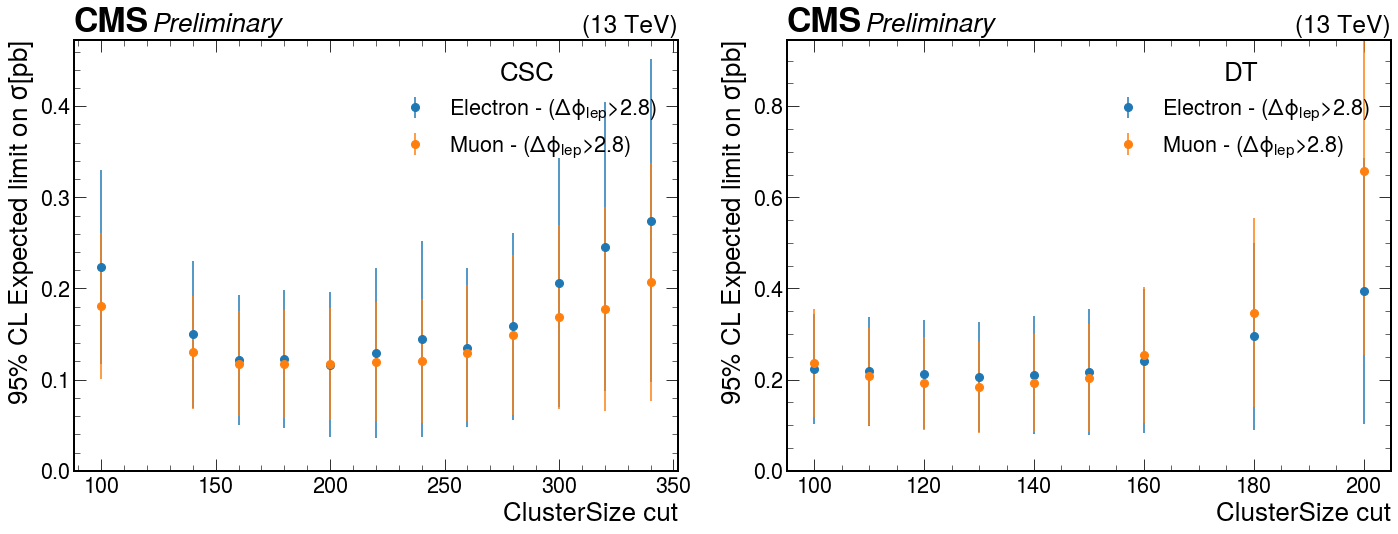

In [78]:
plt.style.use(hep.style.CMS) 

dphiMET = 3.14

y_label=r"95% CL Expected limit on $\sigma$[pb]"
# y_label="Expected background yield"

interpolate=False

dphileps= [2.8]
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs=axs.flatten()

for ax,cls in zip(axs,["CSC","DT"]):
    for lep in ["Electron","Muon"]:
        if (lep,cls)==("Electron","DT") :
#             data = ele_DT
            data = ele_DT
            err  = ele_DTup
        if (lep,cls)==("Electron","CSC"): 
            data = ele_CSC
            err  = ele_CSCup            
        if (lep,cls)==("Muon","CSC"):
            data = mu_CSC
            err  = mu_CSCup            
        if (lep,cls)==("Muon","DT") :
            data = mu_DT
            err  = mu_DTup            
        
        dphilep=2.8
        x = np.array([[k[0],data[k]] for k in data.keys() if k[2]==dphiMET and k[1]==dphilep])
        xerr = np.array([[k[0],err[k]-data[k]] for k in data.keys() if k[2]==dphiMET and k[1]==dphilep])        
        ax.errorbar(x[:,0],x[:,1],xerr[:,1],label = r'%s - ($\Delta\phi_{lep}$>%s)'%(lep,dphilep),ms=8,marker="o",ls="none")

        ax.set_xlabel(r"ClusterSize cut")  
    ymax = 2 if cls=="DT" else 1.
    ax.set_ylim(0,axs[0].get_ylim()[1]*ymax)

    hep.cms.label(ax=ax,label="Preliminary",data=True)
    ax.set_ylim(ax.get_ylim()[0]*0.8,ax.get_ylim()[1])
    channel ="%s"%(cls)
    ax.legend(title=channel,loc=1)    
    ax.set_ylabel(y_label)
    ax.set_ylabel(y_label)    
plt.tight_layout()
plt.savefig("./figures/selection/CutOpt_Scan_ABC_nhit.pdf")

# Bkg yields

In [41]:
mu_CSC_bkg_yields

{(180.0, 2.8, 3.14): [33.5, 6472.0, 834.25, -1.0],
 (200.0, 2.8, 3.14): [21.75, 6483.75, 835.5, -1.0],
 (220.0, 2.8, 3.14): [12.5, 6493.0, 836.25, -1.0],
 (240.0, 2.8, 3.14): [9.75, 6495.75, 836.25, -1.0],
 (260.0, 2.8, 3.14): [6.25, 6499.25, 836.5, -1.0],
 (100.0, 2.8, 3.14): [420.0, 6085.5, 786.0, -1.0],
 (140.0, 2.8, 3.14): [97.5, 6408.0, 827.75, -1.0],
 (160.0, 2.8, 3.14): [59.0, 6446.5, 833.5, -1.0]}

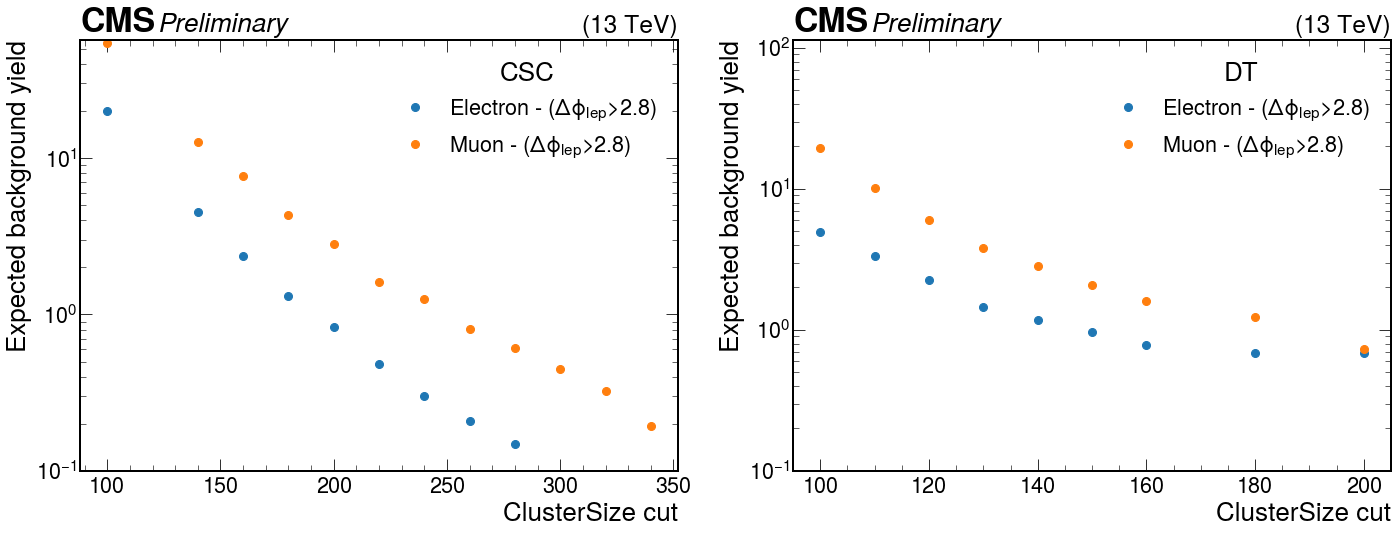

In [82]:
plt.style.use(hep.style.CMS) 

dphiMET = 3.14

# y_label=r"95% CL Expected limit on $\sigma$[pb]"
y_label="Expected background yield"

interpolate=False

dphileps= [2.8]
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs=axs.flatten()

for ax,cls in zip(axs,["CSC","DT"]):
    for lep in ["Electron","Muon"]:
        if (lep,cls)==("Electron","DT") :            data = ele_DT_bkg_yields        
        if (lep,cls)==("Electron","CSC"):             data = ele_CSC_bkg_yields
        if (lep,cls)==("Muon","CSC"):               data = mu_CSC_bkg_yields
        if (lep,cls)==("Muon","DT") :            data = mu_DT_bkg_yields        
        dphilep=2.8
        x = np.array([[k[0],data[k]] for k in data.keys() if k[2]==dphiMET and k[1]==dphilep])
        y = [abcd[0]*abcd[2]/abcd[1] for abcd in x[:,1]]
        ax.errorbar(x[:,0],y,label = r'%s - ($\Delta\phi_{lep}$>%s)'%(lep,dphilep),ms=8,marker="o",ls="none")    
        ax.set_xlabel(r"ClusterSize cut")  
    ymax = 2 if cls=="DT" else 1.
    ax.set_ylim(0,axs[0].get_ylim()[1]*ymax)

    hep.cms.label(ax=ax,label="Preliminary",data=True)
    ax.set_ylim(ax.get_ylim()[0]*0.8,ax.get_ylim()[1])
    channel ="%s"%(cls)
    ax.legend(title=channel,loc=1)    
    ax.set_ylabel(y_label)
    ax.set_ylim(0.1,None)
    ax.set_yscale('log')
plt.tight_layout()
plt.savefig("./figures/selection/CutOpt_Scan_nbkg.pdf")

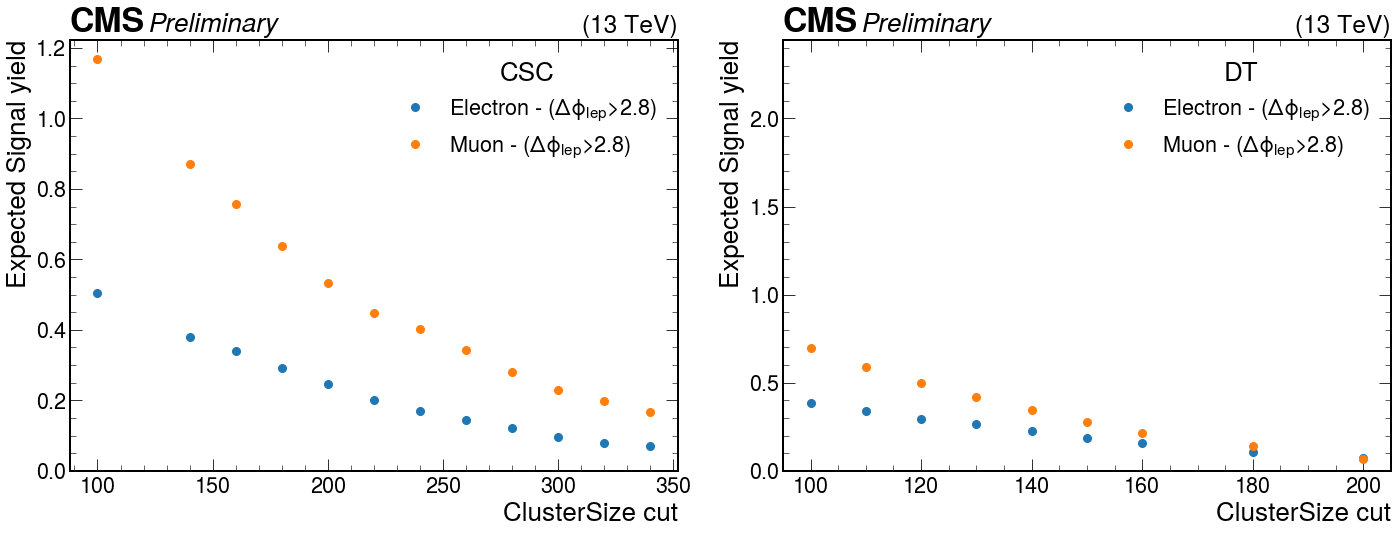

In [52]:
plt.style.use(hep.style.CMS) 

dphiMET = 3.14

# y_label=r"95% CL Expected limit on $\sigma$[pb]"
y_label="Expected Signal yield"

interpolate=False

dphileps= [2.8]
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs=axs.flatten()

for ax,cls in zip(axs,["CSC","DT"]):
    for lep in ["Electron","Muon"]:
        if (lep,cls)==("Electron","DT") :            data = ele_DT_sig_yields        
        if (lep,cls)==("Electron","CSC"):             data = ele_CSC_sig_yields
        if (lep,cls)==("Muon","CSC"):            data = mu_CSC_sig_yields
        if (lep,cls)==("Muon","DT") :            data = mu_DT_sig_yields
        
        dphilep=2.8
        x = np.array([[k[0],data[k]] for k in data.keys() if k[2]==dphiMET and k[1]==dphilep])
        y = [abcd[-1] for abcd in x[:,1]]
        ax.errorbar(x[:,0],y,label = r'%s - ($\Delta\phi_{lep}$>%s)'%(lep,dphilep),ms=8,marker="o",ls="none")    
        ax.set_xlabel(r"ClusterSize cut")  
    ymax = 2 if cls=="DT" else 1.
    ax.set_ylim(0,axs[0].get_ylim()[1]*ymax)

    hep.cms.label(ax=ax,label="Preliminary",data=True)
    ax.set_ylim(ax.get_ylim()[0]*0.8,ax.get_ylim()[1])
    channel ="%s"%(cls)
    ax.legend(title=channel,loc=1)    
    ax.set_ylabel(y_label)
plt.tight_layout()

# Dphilep scan

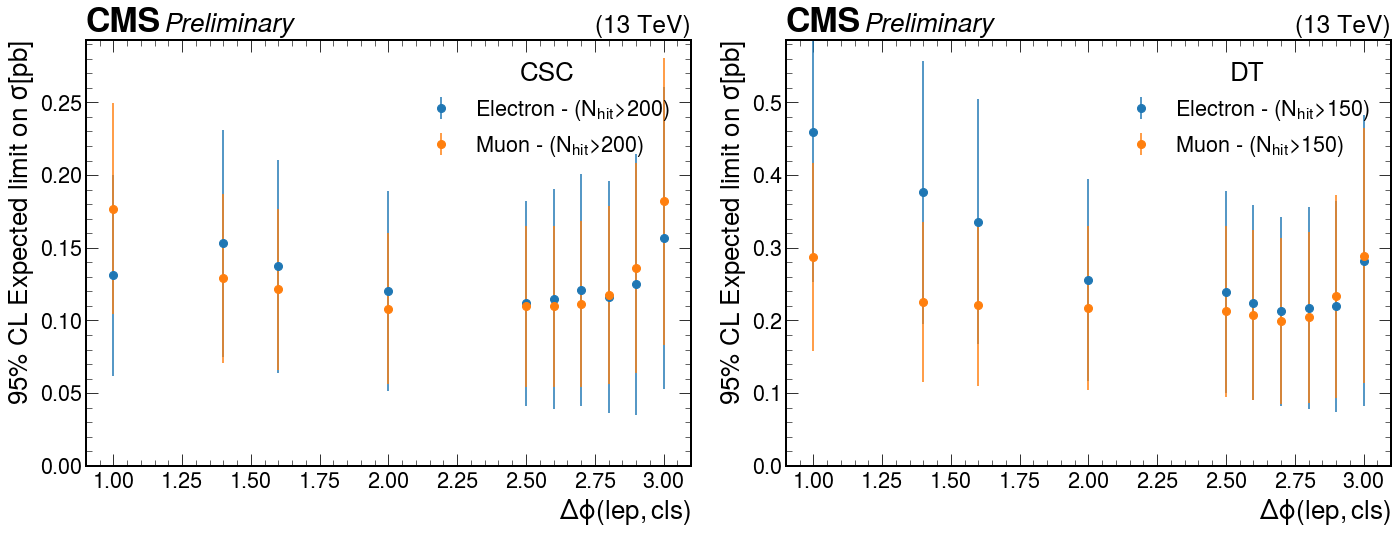

In [79]:
plt.style.use(hep.style.CMS) 

dphiMET = 3.14

y_label=r"95% CL Expected limit on $\sigma$[pb]"
# y_label="Expected background yield"

interpolate=False

dphileps= [2.8]
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs=axs.flatten()

for ax,cls in zip(axs,["CSC","DT"]):
    for lep in ["Electron","Muon"]:
        if (lep,cls)==("Electron","DT") :
            data = ele_DT
            err  = ele_DTup
        if (lep,cls)==("Electron","CSC"): 
            data = ele_CSC
            err  = ele_CSCup            
        if (lep,cls)==("Muon","CSC"):
            data = mu_CSC
            err  = mu_CSCup            
        if (lep,cls)==("Muon","DT") :
            data = mu_DT
            err  = mu_DTup            
        
        if cls == "DT" : nhit=150
        if cls == "CSC": nhit =200
        x = np.array([[k[1],data[k]] for k in data.keys() if k[2]==dphiMET and k[0]==nhit])
        xerr = np.array([[k[1],err[k]-data[k]] for k in data.keys() if k[2]==dphiMET and k[0]==nhit])        
        ax.errorbar(x[:,0],x[:,1],xerr[:,1],label = r'%s - ($N_{hit}$>%s)'%(lep,nhit),ms=8,marker="o",ls="none")

        ax.set_xlabel(r"$\Delta\phi(lep,cls)$")  
    ymax = 2 if cls=="DT" else 1.
    ax.set_ylim(0,axs[0].get_ylim()[1]*ymax)

    hep.cms.label(ax=ax,label="Preliminary",data=True)
    ax.set_ylim(ax.get_ylim()[0]*0.8,ax.get_ylim()[1])
    channel ="%s"%(cls)
    ax.legend(title=channel,loc=1)    
    ax.set_ylabel(y_label)
    ax.set_ylabel(y_label)    
plt.tight_layout()
plt.savefig("./figures/selection/CutOpt_Scan_ABC_dphi.pdf")